In [1]:
import pandas as pd

from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine

In [2]:
engine = create_engine("sqlite:///../db/doggo-db.sqlite")

In [3]:
Base = automap_base()
Base.prepare(engine, reflect=True)

In [4]:
Babies = Base.classes.babies
Doggos = Base.classes.doggos

In [5]:
session = Session(engine)

In [6]:
babies = [baby for baby in session.query(Babies.brth_yr, Babies.gndr, Babies.ethcty, Babies.nm, Babies.cnt)]
doggos = [doggo for doggo in session.query(Doggos.animalname, Doggos.animalgender, Doggos.animalbirth, Doggos.zipcode, Doggos.extract_year)]

In [7]:
babies_df = pd.DataFrame(babies, columns=['Birth_Year', 'Gender', 'Ethnicity', 'Name', 'Count'])
babies_df.head()

,Birth_Year,Gender,Ethnicity,Name,Count
0,2016,FEMALE,ASIAN AND PACIFIC ISLANDER,Olivia,172
1,2016,FEMALE,ASIAN AND PACIFIC ISLANDER,Chloe,112
2,2016,FEMALE,ASIAN AND PACIFIC ISLANDER,Sophia,104
3,2016,FEMALE,ASIAN AND PACIFIC ISLANDER,Emily,99
4,2016,FEMALE,ASIAN AND PACIFIC ISLANDER,Emma,99


In [8]:
babies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27491 entries, 0 to 27490
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Birth_Year  27491 non-null  int64 
 1   Gender      27491 non-null  object
 2   Ethnicity   27491 non-null  object
 3   Name        27491 non-null  object
 4   Count       27491 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.0+ MB


In [9]:
babies_df = babies_df.drop_duplicates()
babies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12181 entries, 0 to 27459
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Birth_Year  12181 non-null  int64 
 1   Gender      12181 non-null  object
 2   Ethnicity   12181 non-null  object
 3   Name        12181 non-null  object
 4   Count       12181 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 571.0+ KB


In [10]:
babies_df['Name'] = babies_df['Name'].str.upper()

In [11]:
babies_df['Name'] = babies_df['Name'].str.replace('[^\w\s]','')

In [12]:
babies_total = babies_df.groupby(['Name'])['Count'].sum().to_frame()

In [13]:
doggos_df = pd.DataFrame(doggos, columns=['Name', 'Gender', 'Birth_Year', 'Zip_Code', 'Extract'])
doggos_df.head()

,Name,Gender,Birth_Year,Zip_Code,Extract
0,PAIGE,None Specified,2014,10035,2016
1,YOGI,None Specified,2010,10465,2016
2,ALI,None Specified,2014,10013,2016
3,QUEEN,None Specified,2013,10013,2016
4,LOLA,None Specified,2009,10028,2016


In [14]:
doggos_df_2018 = doggos_df.groupby('Extract').get_group(2018).reset_index(drop=True)
doggos_df_2018.head()

,Name,Gender,Birth_Year,Zip_Code,Extract
0,ALI,M,2014,10013,2018
1,IAN,M,2006,10013,2018
2,CHEWBACCA,F,2012,10013,2018
3,LOLA,F,2006,10022,2018
4,LUCY,F,2014,11215,2018


In [15]:
doggos_df_2018['Name'] = doggos_df_2018['Name'].str.upper()

In [16]:
doggos_df_2018['Name'] = doggos_df_2018['Name'].str.replace('[^\w\s]','')

In [17]:
doggos_df_2018 = doggos_df_2018.loc[(doggos_df_2018['Birth_Year'] >= 2011) & (doggos_df_2018['Birth_Year'] <= 2016)]
doggos_df_2018.head(20)

,Name,Gender,Birth_Year,Zip_Code,Extract
0,ALI,M,2014,10013,2018
2,CHEWBACCA,F,2012,10013,2018
4,LUCY,F,2014,11215,2018
6,APPLE,M,2013,10025,2018
7,MUNECA,F,2013,11232,2018
10,SOPHIE,F,2011,10308,2018
11,ELIZABETH,F,2013,10022,2018
12,AVERY,F,2014,10002,2018
14,BUDDY,M,2012,10312,2018
17,DEDE,M,2013,11236,2018


In [18]:
doggos_ranked = doggos_df_2018.groupby(['Name'])['Name'].size().to_frame()
doggos_ranked = doggos_ranked.rename(columns={'Name': 'Count'})

In [19]:
merged_df = doggos_ranked.merge(babies_total, left_on='Name', right_on='Name', suffixes=('_doggos', '_babies'))

In [20]:
merged_df.head(20)

,Count_doggos,Count_babies
Name,,
AALIYAH,2,737
AARON,3,1845
ABBY,87,118
ABEL,2,141
ABIGAIL,28,1742
ABRAHAM,5,1133
ABRIL,1,10
ADA,3,107
ADAM,5,1562


In [21]:
dogs_total = merged_df['Count_doggos'].sum()
babies_total = merged_df['Count_babies'].sum()

In [22]:
merged_df['Per_100k_doggos'] = 100000 * merged_df['Count_doggos'] / dogs_total
merged_df['Per_100k_babies'] = 100000 * merged_df['Count_babies'] / babies_total

In [25]:
merged_df

,Count_doggos,Count_babies,Per_100k_doggos,Per_100k_babies
Name,,,,
AALIYAH,2,737,10.109690,217.704678
AARON,3,1845,15.164535,545.000177
ABBY,87,118,439.771521,34.856380
ABEL,2,141,10.109690,41.650420
ABIGAIL,28,1742,141.535662,514.574693
...,...,...,...,...
ZION,7,337,35.383915,99.547458
ZOE,110,1454,556.032958,429.501495
ZOEY,155,669,783.500986,197.617950


In [30]:
cutoff_df = merged_df.loc[(merged_df['Per_100k_doggos'] >= 100) & (merged_df['Per_100k_babies'] >= 100)]

In [31]:
cutoff_df

,Count_doggos,Count_babies,Per_100k_doggos,Per_100k_babies
Name,,,,
ABIGAIL,28,1742,141.535662,514.574693
ALICE,22,655,111.206592,193.482448
AMY,20,635,101.096901,187.574587
ANDY,29,463,146.590507,136.766982
ANGEL,61,1472,308.345549,434.818570
...,...,...,...,...
THEODORE,33,732,166.809887,216.227713
TYLER,20,1217,101.096901,359.493342
VIOLET,38,472,192.084113,139.425520


In [33]:
def get_percent_diff(val1, val2):
    diff = abs(val1 - val2)
    avg = (val1 + val2) / 2
    return 100 * diff / avg

In [34]:
cutoff_df['Percent_diff'] = get_percent_diff(cutoff_df['Per_100k_babies'], cutoff_df['Per_100k_doggos'])

/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [35]:
cutoff_df

,Count_doggos,Count_babies,Per_100k_doggos,Per_100k_babies,Percent_diff
Name,,,,,
ABIGAIL,28,1742,141.535662,514.574693,113.712283
ALICE,22,655,111.206592,193.482448,54.006443
AMY,20,635,101.096901,187.574587,59.914255
ANDY,29,463,146.590507,136.766982,6.933662
ANGEL,61,1472,308.345549,434.818570,34.036363
...,...,...,...,...,...
THEODORE,33,732,166.809887,216.227713,25.803120
TYLER,20,1217,101.096901,359.493342,112.202307
VIOLET,38,472,192.084113,139.425520,31.768967


In [50]:
cutoff_df = cutoff_df.sort_values(by=['Percent_diff'], ascending=False)

In [41]:
cutoff_df.head(25)

,Count_doggos,Count_babies,Per_100k_doggos,Per_100k_babies,Percent_diff
Name,,,,,
MILES,30,523,151.645352,154.490565,1.858791
LUCA,38,623,192.084113,184.029870,4.282873
MAYA,78,1262,394.277915,372.786029,5.603675
ANDY,29,463,146.590507,136.766982,6.933662
MILA,42,651,212.303493,192.300876,9.887495
KAI,22,416,111.206592,122.883509,9.976430
LUKE,57,874,288.126169,258.173526,10.965645
FAITH,20,402,101.096901,118.748006,16.057779
ELEANOR,27,389,136.480817,114.907896,17.162998


In [48]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

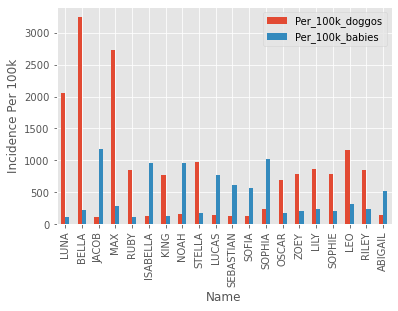

In [51]:
cutoff_df[['Per_100k_doggos', 'Per_100k_babies']][:20].plot.bar()
plt.ylabel('Incidence Per 100k')
plt.show()